# MROiPUM Tutorial





## "Feature-based" algorytmy rozpoznawania twarzy
### Wykorzystanie klasyfikatorów kaskadowych przy użyciu metody Haara
Podejście to polega na trenowaniu funkcji kaskadowych z wielu obrazów pozytywnych(zawierających twarz) oraz negatywnych(bez twarzy).

###Cechy (features)
Następnie ze wszystkich zdjęć musimy wybrać zbiór cech. Wybieramy cechy, a nie bezpośrednio piksele ze względu na szybkość działania końcowej detekcji.
Do tego celu wykorzystuje się 3 rodzaje cech.

![alt text](https://1.bp.blogspot.com/_kJR2Jk6iMhg/SgfVFkDZJ9I/AAAAAAAAAB0/1FC1QhfIgb8/s280/01.JPG)
![alt text](https://docs.opencv.org/3.4/haar_features.jpg)

 

*   Wartością cechy złożonej z dwóch prostokątów jest różnica sum wartości pikseli w obrębie obszaru. Obszary są tej samej wielkości oraz mają taki sam kształt.
*   Dla cechy złożonej z trzech prostokątów wartość liczymy jako różnicę sumy środkowego obszarów oraz sumy dwóch zewnętrznych obszarów
* Wartość cztero-obszarowej cechy liczymy jako różnicę par pól na przekątnych

Zakładając, że obszar detekcji jest wielkości 24x24, liczba wszystkich możliwych cech wynosi ponad 180 000. Dla każdej cechy musimy policzyć sumę pikseli na białym oraz szarym polu. Aby usprawnić szybkość liczenia wprowadzono reprezentację obrazu "integral image".
Integral image w punkcie x,y zawiera sumę pikseli powyżej y oraz na lewo od x.
\begin{equation}
ii(x,y) = \sum_{x'\le x, y' \le y} i(x',y')
\end{equation}
![alt text](https://drive.google.com/uc?id=1iWIaEQIymlYnpRpDj_mddOz4L2g9Nuvq)

Dzięki temu jesteśmy w stanie policzyć sumę pojedynczego obszaru w 4 odwołaniach do tablicy.

Liczba odwołań dla obszaru:
* dwu-prostokątnego: 6
* trzy-prostokątnego: 8
* cztero-prostokątnego: 9





Większość obliczonych wcześniej cech jest nieistotnych z punktu widzenia detekcji. Weźmy za przykład takie cechy:

![alt text](https://docs.opencv.org/3.4/haar.png)

Pierwsza cecha skupia się na własności, w której obszar oczu jest zazwyczaj ciemniejszy niż obszar nosa i policzków. Druga cecha natomiast podkreśla, że obszar oczu jest ciemniejszy niż podstawa nosa.
Te same cechy przesunięte na obszar czoła, tracą jakiekolwiek znaczenie z punkty widzenia detekcji. Z tego powodu do wybrania tylko najbardziej znaczących cech stosujemy algorytm Adaboost. 

####Adaboost
Jako pierwszy krok inicjalizujemy obrazki z początkową wagą. Następnie nakładamy poszczególne cechy na obrazy, trenujemy klasyfikator i wyliczamy stopień błędu.
Spośród wszystkich klasyfikatorów wybieramy ten z najmniejszym stopniem błędu i aktualizujemy wagi. Powtarzamy poprzednie kroki do momentu uzyskania określonej dokładnościu lub liczby cech.

Szczegółowy przebieg algorytmu:
\begin{equation}
h_j(x)\text{- słaby klasyfikator}
\end{equation}

\begin{equation}
h_j(x) = 
  \begin{cases}
      1 & \text{if } p_jf_j(x) < p_j\theta_j \\
      0 & \text{otherwise}
    \end{cases} 
    \text{gdzie } f_j\text{- cecha, } \theta_j\text{- próg, } p_j\text{-wskaźnik wskazujący kierunek nierówności }
\end{equation}
![alt text](https://drive.google.com/uc?id=1dAUOdaDfYYZN8kkGhz1FJf9A8CWw3QM6)

Końcowy klasyfikator, który otrzymujemy jest ważoną sumą pojedynczych klasyfikatorów, 
których użyliśmy do tej pory. Każdy z nich z osobna nie mógłby poslużyć do rozpoznawania obrazów,
ale łącznie ułożone w odpowiedniej kolejności i z odpowiednio dobranymi wagami dają bardzo dużą dokładność
(dla 200 cech 95% poprawność detekcji)

Kaskada klasyfikatorów umożliwia stopniowe odrzucanie fragmentów obrazka,
gdzie prawdopodobieństwo znalezienia poszukiwanego obiektu jest bardzo małe.
Dzięki temu nie marnujemy czasu na przetwarzanie owych miejsc, które stanowią zwykle większość obrazu.
* Początkowo mamy bardzo wiele cech dla pojendynczego okienka. 
Jeśli w pierszym etapie fragment zostanie negatywnie zaklasyfikowany - jest odrzucany i nie jest brany pod uwagę w kolejnych etapach. Jeśli pozytywnie, sprawdzane są kolejne zestawy cech.
* Gdy przejdzie pozywnie wszystkie etapy, klasyfikowany jest ostatecznie jako miejsce położenia szukanego obiektu.


In [0]:
import cv2 as cv

## Obrazy
Do testów wykorzystamy następujące 2 zdjęcia, z których drugie będzie bardziej wymagające dla klasyfikatorów ze względu na nietypową pozycję twarzy niektórych osób:


![people group](https://cdn.geekwire.com/wp-content/uploads/2019/12/GroupPhoto-e1577801886654-630x557.jpg)
![friends](https://www.homestaynetwork.org/wp-content/uploads/2019/06/bigstock-Group-of-funny-teenagers-indoo-220446625.jpg)


In [0]:
# Clone the entire repo.
!git clone -l -s https://github.com/opencv/opencv.git cloned-repo
%cd cloned-repo
!ls

Cloning into 'cloned-repo'...
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 273418 (delta 0), reused 1 (delta 0), pack-reused 273414
Receiving objects: 100% (273418/273418), 469.04 MiB | 29.13 MiB/s, done.
Resolving deltas: 100% (191016/191016), done.
Checking out files: 100% (6181/6181), done.
/content/cloned-repo
3rdparty  CMakeLists.txt   doc	    modules    samples
apps	  CONTRIBUTING.md  include  platforms  SECURITY.md
cmake	  data		   LICENSE  README.md


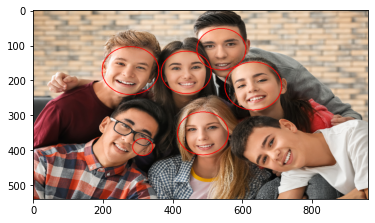

In [0]:
from __future__ import print_function
import cv2 as cv
import argparse
import urllib.request
import numpy as np
from matplotlib import pyplot as plt

def detectAndDisplay(frame):
    frame_gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    frame_gray = cv.equalizeHist(frame_gray)

    faces = face_cascade.detectMultiScale(frame_gray)
    for (x,y,w,h) in faces:
        center = (x + w//2, y + h//2)
        frame = cv.ellipse(frame, center, (w//2, h//2), 0, 0, 360, (0, 0, 255), 5)
        faceROI = frame_gray[y:y+h,x:x+w]

    out = cv.resize(frame, (960, 540))
    plt.imshow(cv.cvtColor(out, cv.COLOR_BGR2RGB))
    # cv.imshow('Capture - Face detection', out)


def url_to_image(url):
    resp = urllib.request.urlopen(url)
    image = np.asarray(bytearray(resp.read()), dtype="uint8")
    image = cv.imdecode(image, cv.IMREAD_COLOR)
    return image
face_cascade_name = '/content/cloned-repo/data/haarcascades/haarcascade_frontalface_alt.xml'
face_cascade = cv.CascadeClassifier()

if not face_cascade.load(cv.samples.findFile(face_cascade_name)):
    print('--(!)Error loading face cascade')
    exit(0)

img = url_to_image('https://www.homestaynetwork.org/wp-content/uploads/2019/06/bigstock-Group-of-funny-teenagers-indoo-220446625.jpg')
detectAndDisplay(img)


### Wielozadaniowe kaskadowe splotowe sieci neuronowe


Metoda opisana do tej pory dobrze sprawdza się w typowych sytuacjach, wykazując się dużą efektywnością, może jednak zawodzić przy nietypowych pozycjach twarzy, co dowodzi powyższe zdjęcie.
Obecnie z powodzeniem wykorzystuje się convolutional neural network (CNN) do poprawienia uzyskiwanych rezultatów w dziedzinie klasyfikacji obrazów i rozpoznawania twarzy.


Przedstawiona poniżej metoda łączy zadanie rozpoznawania twarzy z zadaniem wyrównywania korzystając z nieodłącznej korelacji między nimi.
Składa się z 3 etapów:
* Najpierw następuje wybranie obiecujących fragmentów obrazka oraz wektorów regresji obwiedni z wykorzystaniem płytkiej sieci CNN: Proposal Network (P-Net). Następnie wykorzystuje się wspomniane wektory do kalibracji kandydatów. Okna, które w dużej mierze się pokrywają są łączone. 
* Kolejnym etapem jest wykorzystanie bardziej złożonej sieci CNN: Refine Network (R-Net), ktora odrzuca wielu spośrod wybranych do tej pory kandydatów oraz powiela wykonane w pierwszym kroku czynności.
* Wykonanie ostatniego kroku umożliwia uzyskanie dokładnego położenia twarzy wraz z określeniem pozycji oczu, czubka nosa i kącików ust.


In [0]:
!python -m pip install mtcnn tensorflow

In [0]:
from mtcnn import MTCNN

Using TensorFlow backend.


In [0]:
def draw_details(img, faces):
  for face in faces:
    x = face.get('box')[0]
    y = face.get('box')[1]
    w = face.get('box')[2]
    h = face.get('box')[3]
    img = cv.rectangle(img, (x,y), (x+w,y+h), (255, 0, 0), 5) #image, p1, p2, color, thickness
    img = cv.circle(img, face.get('keypoints').get('left_eye'), 10, (0, 0, 255), 5) #image, center, radius, color, thickness
    img = cv.circle(img, face.get('keypoints').get('right_eye'), 10, (0, 0, 255), 5)
    img = cv.circle(img, face.get('keypoints').get('nose'), 10, (0, 0, 255), 5)
    img = cv.circle(img, face.get('keypoints').get('mouth_right'), 10, (0, 255, 0), 5)
    img = cv.circle(img, face.get('keypoints').get('mouth_left'), 10, (0, 255, 0), 5)

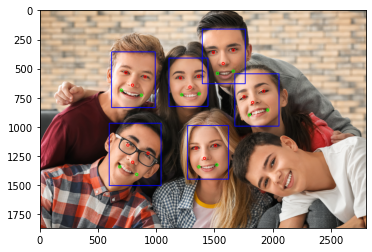

In [0]:
img = url_to_image('https://www.homestaynetwork.org/wp-content/uploads/2019/06/bigstock-Group-of-funny-teenagers-indoo-220446625.jpg')
detector = MTCNN()
draw_details(img, detector.detect_faces(img))
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))

## Zadanie:
Przetestuj działanie obu metod na wybranym przez siebie zdjęciu.